# TD : Arbres de Décision pour la Finance
## Master 2 Banque Finance Assurance - Paris Dauphine

**Durée totale :** 3 heures  
**Objectifs pédagogiques :**
- Comprendre l'algorithme CART et ses critères de division
- Maîtriser les techniques de régularisation (pruning)
- Interpréter les modèles d'arbres de décision
- Appliquer les arbres à des problématiques bancaires et financières

---

## 📚 Partie 1 : Théorie (30 minutes)

### 1.1 Introduction aux Arbres de Décision

Les arbres de décision sont des modèles de machine learning **interprétables** particulièrement adaptés au secteur financier où la **transparence** et l'**explicabilité** sont essentielles (réglementation Bâle III, RGPD, etc.).

**Avantages :**
- ✅ Interprétabilité maximale (structure if-then)
- ✅ Pas de normalisation nécessaire
- ✅ Gestion automatique des interactions entre variables
- ✅ Robustes aux outliers

**Inconvénients :**
- ❌ Tendance au surapprentissage
- ❌ Instabilité (petite variation des données → arbre différent)
- ❌ Frontières de décision orthogonales

### 1.2 L'Algorithme CART (Classification And Regression Trees)

CART construit un arbre binaire en **divisant récursivement** l'espace des variables.

#### Critères de division pour la classification :

**1. Indice de Gini (utilisé par défaut dans scikit-learn)**

$$
\text{Gini}(t) = 1 - \sum_{i=1}^{C} p_i^2
$$

où $p_i$ est la proportion de la classe $i$ dans le nœud $t$.

- Gini = 0 : nœud pur (toutes les observations de la même classe)
- Gini = 0.5 : impureté maximale (pour 2 classes équilibrées)

**2. Entropie (critère de Shannon)**

$$
\text{Entropy}(t) = - \sum_{i=1}^{C} p_i \log_2(p_i)
$$

### 1.3 Overfitting et Techniques de Pruning

#### Problème d'overfitting

Un arbre non contrôlé va continuer à se diviser jusqu'à avoir des feuilles pures → **mémorisation** des données d'entraînement plutôt que **généralisation**.

#### Solutions : Régularisation

**1. Pre-pruning (arrêt précoce) - Paramètres scikit-learn :**

| Paramètre | Description | Valeur typique |
|-----------|-------------|----------------|
| `max_depth` | Profondeur maximale de l'arbre | 3-10 |
| `min_samples_split` | Nombre min d'observations pour diviser un nœud | 20-100 |
| `min_samples_leaf` | Nombre min d'observations dans une feuille | 10-50 |
| `max_leaf_nodes` | Nombre maximum de feuilles | 10-50 |
| `min_impurity_decrease` | Gain min requis pour diviser | 0.001-0.01 |

**2. Post-pruning (élagage) - Paramètre scikit-learn :**

- `ccp_alpha` : Complexité Cost Complexity Pruning
  - Plus alpha est grand, plus l'arbre est élagué
  - Utiliser `cost_complexity_pruning_path()` pour trouver les valeurs optimales

**Stratégie recommandée :**
1. Entraîner un arbre complet
2. Évaluer sur validation set
3. Ajuster les hyperparamètres via GridSearchCV ou validation croisée

### 1.4 Interprétabilité des Arbres de Décision

#### Pourquoi c'est crucial en finance ?

- **Réglementation :** Bâle III exige l'explicabilité des modèles de risque
- **RGPD :** Droit à l'explication des décisions automatisées
- **Validation interne :** Les comités de risque doivent comprendre les modèles
- **Confiance client :** Expliquer un refus de crédit

#### Outils d'interprétation

**1. Visualisation de l'arbre**
```python
from sklearn.tree import plot_tree
plot_tree(model, feature_names=X.columns, class_names=['Non', 'Oui'], filled=True)
```

**2. Importance des variables**
```python
model.feature_importances_
```
Calculée comme la **réduction moyenne d'impureté** apportée par chaque variable.

**3. Chemin de décision individuel**
```python
tree.decision_path(X_sample)
```
Permet de tracer le chemin exact d'une observation dans l'arbre.

**Attention :** L'importance des variables peut être biaisée si des variables sont corrélées !

Visualisation du processus d'apprentissage

ITÉRATION 1 : Premier Split (profondeur 1)


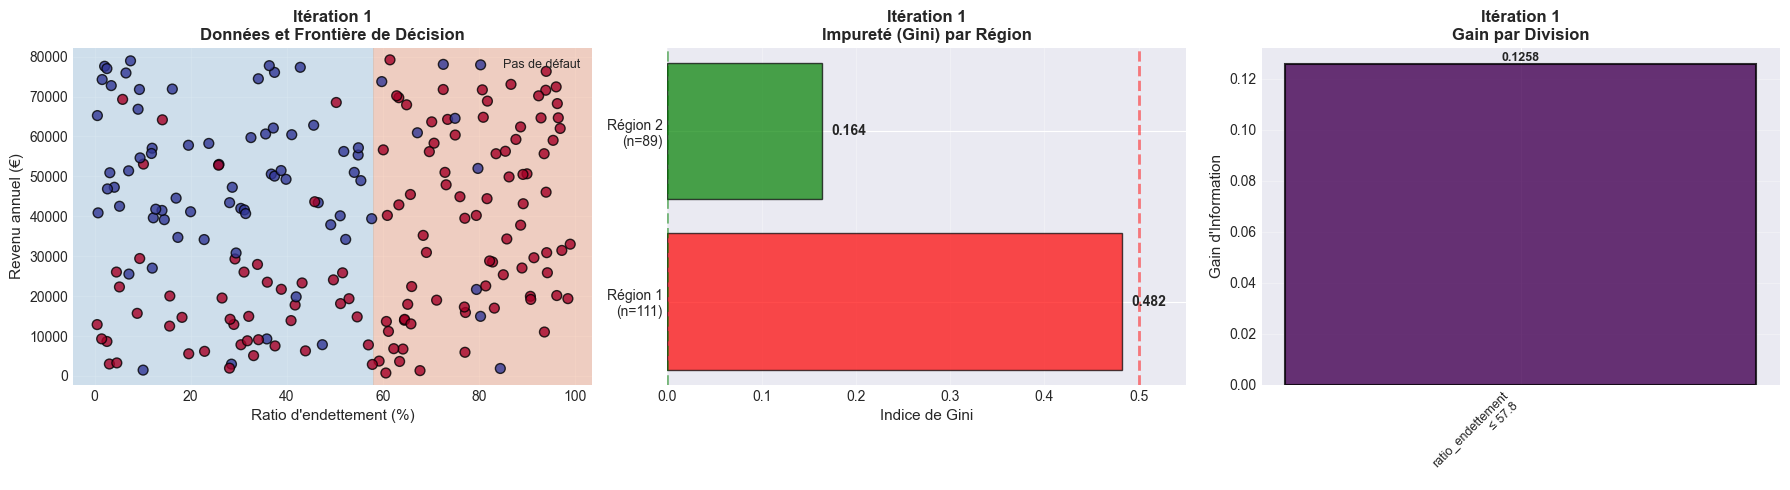


   Itération 1 - Statistiques :
   - Profondeur : 1
   - Nombre de feuilles : 2
   - Accuracy : 0.735

ITÉRATION 2 : Deuxième niveau (profondeur 2)


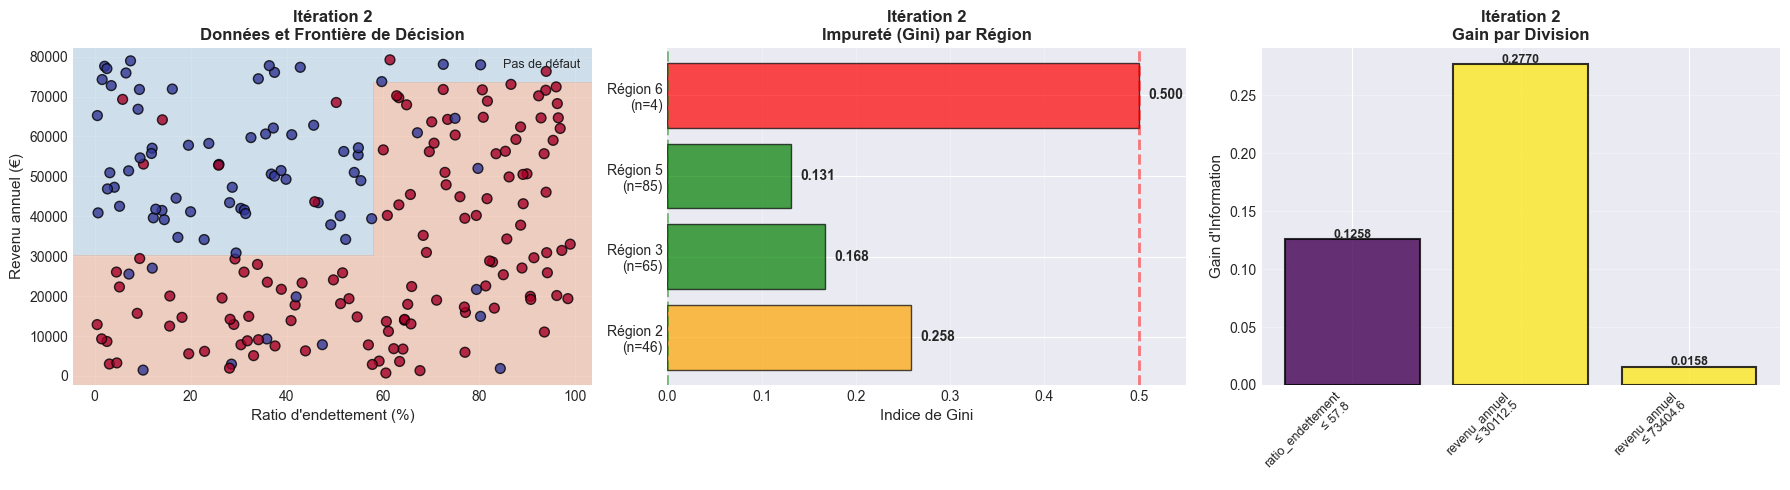


   Itération 2 - Statistiques :
   - Profondeur : 2
   - Nombre de feuilles : 4
   - Accuracy : 0.895

ITÉRATION 3 : Troisième niveau (profondeur 3)


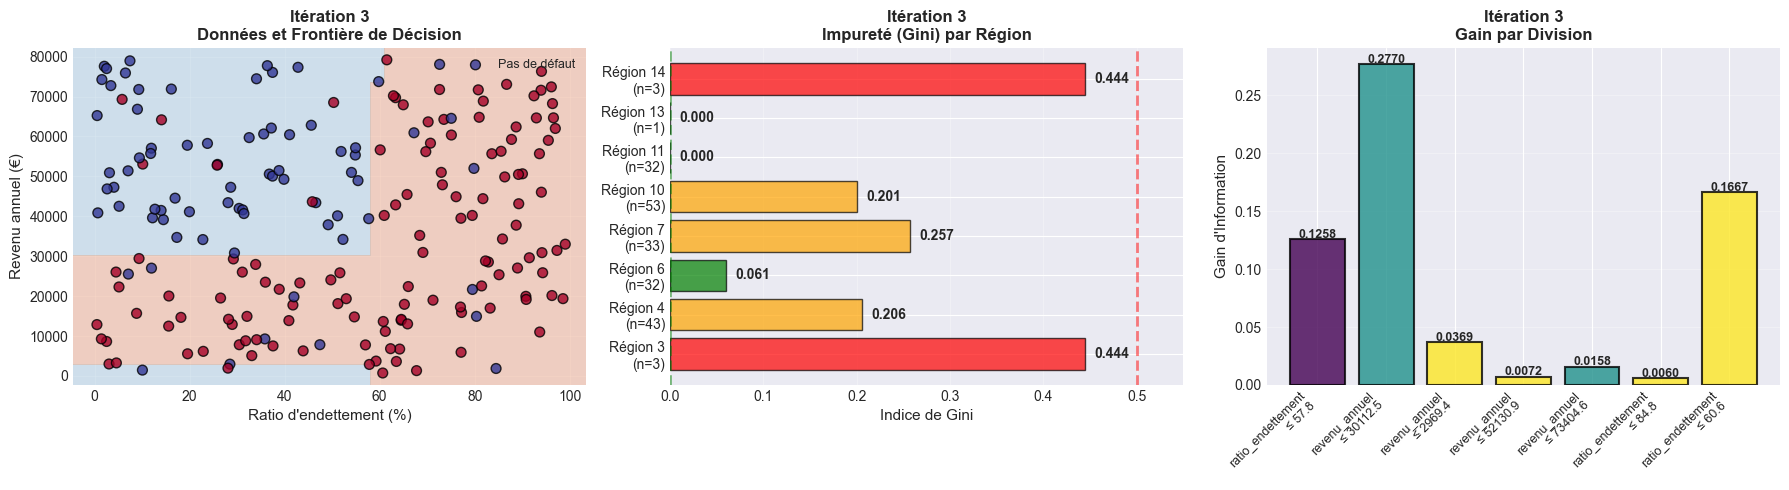


   Itération 3 - Statistiques :
   - Profondeur : 3
   - Nombre de feuilles : 8
   - Accuracy : 0.905


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

# Génération de données 2D
np.random.seed(42)
n = 200
X_viz = np.random.rand(n, 2)
X_viz[:, 0] = X_viz[:, 0] * 100  # Ratio d'endettement (0-100%)
X_viz[:, 1] = X_viz[:, 1] * 80000  # Revenu annuel (0-80k)

# Règle métier : défaut si endettement > 60% OU revenu < 30k
y_viz = ((X_viz[:, 0] > 60) | (X_viz[:, 1] < 30000)).astype(int)

# Ajout de bruit
noise_idx = np.random.choice(n, size=int(0.1*n), replace=False)
y_viz[noise_idx] = 1 - y_viz[noise_idx]

def calculate_gini(y):
    """Calcule le Gini d'un ensemble d'observations"""
    if len(y) == 0:
        return 0
    p = np.sum(y) / len(y)
    return 1 - (p**2 + (1-p)**2)

def visualize_iteration(X, y, max_depth, iteration_name):
    """
    Visualise une itération de l'apprentissage avec 3 graphiques :
    1. Données + frontière de décision
    2. Gini de chaque région
    3. Gains d'information des divisions
    """
    # Entraînement
    tree = DecisionTreeClassifier(max_depth=max_depth, criterion='gini', random_state=42)
    tree.fit(X, y)
    
    fig = plt.figure(figsize=(18, 5))
    
    # === GRAPHIQUE 1 : Données + Frontière ===
    ax1 = plt.subplot(131)
    
    # Grille pour la frontière
    h = 1.0
    x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
    y_min, y_max = X[:, 1].min() - 3000, X[:, 1].max() + 3000
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Frontière
    ax1.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu_r', levels=1)
    
    # Points
    scatter = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu_r', 
                         edgecolors='black', s=50, alpha=0.8)
    
    ax1.set_xlabel('Ratio d\'endettement (%)', fontsize=11)
    ax1.set_ylabel('Revenu annuel (€)', fontsize=11)
    ax1.set_title(f'{iteration_name}\nDonnées et Frontière de Décision', 
                 fontsize=12, fontweight='bold')
    ax1.legend(*scatter.legend_elements(), loc='upper right', 
              labels=['Pas de défaut', 'Défaut'], fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # === GRAPHIQUE 2 : Impureté (Gini) par région ===
    ax2 = plt.subplot(132)
    
    leaf_ids = tree.apply(X)
    unique_leaves = np.unique(leaf_ids)
    
    gini_values = []
    leaf_labels = []
    
    for leaf_id in unique_leaves:
        mask = leaf_ids == leaf_id
        y_leaf = y[mask]
        gini = calculate_gini(y_leaf)
        gini_values.append(gini)
        n_samples = len(y_leaf)
        leaf_labels.append(f'Région {leaf_id}\n(n={n_samples})')
    
    colors_gini = ['green' if g < 0.2 else 'orange' if g < 0.4 else 'red' 
                   for g in gini_values]
    bars = ax2.barh(leaf_labels, gini_values, color=colors_gini, 
                   alpha=0.7, edgecolor='black')
    
    for i, (bar, gini) in enumerate(zip(bars, gini_values)):
        ax2.text(gini + 0.01, i, f'{gini:.3f}', va='center', 
                fontsize=10, fontweight='bold')
    
    ax2.set_xlabel('Indice de Gini', fontsize=11)
    ax2.set_title(f'{iteration_name}\nImpureté (Gini) par Région', 
                 fontsize=12, fontweight='bold')
    ax2.set_xlim(0, 0.55)
    ax2.axvline(x=0, color='green', linestyle='--', alpha=0.5, linewidth=2)
    ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, linewidth=2)
    ax2.grid(axis='x', alpha=0.3)
    
    # === GRAPHIQUE 3 : Gain d'information ===
    ax3 = plt.subplot(133)
    
    tree_info = tree.tree_
    feature_names = ['ratio_endettement', 'revenu_annuel']
    
    gains_info = []
    
    def traverse_tree(node_id, depth=0):
        if tree_info.feature[node_id] != -2:  # Pas une feuille
            parent_impurity = tree_info.impurity[node_id]
            left_child = tree_info.children_left[node_id]
            right_child = tree_info.children_right[node_id]
            
            n_parent = tree_info.n_node_samples[node_id]
            n_left = tree_info.n_node_samples[left_child]
            n_right = tree_info.n_node_samples[right_child]
            
            weighted_impurity = (n_left/n_parent * tree_info.impurity[left_child] + 
                               n_right/n_parent * tree_info.impurity[right_child])
            
            gain = parent_impurity - weighted_impurity
            
            feature_name = feature_names[tree_info.feature[node_id]]
            threshold = tree_info.threshold[node_id]
            
            gains_info.append({
                'split': f'{feature_name}\n≤ {threshold:.1f}',
                'gain': gain,
                'depth': depth
            })
            
            traverse_tree(left_child, depth+1)
            traverse_tree(right_child, depth+1)
    
    traverse_tree(0)
    
    if len(gains_info) > 0:
        splits = [g['split'] for g in gains_info]
        gains = [g['gain'] for g in gains_info]
        depths = [g['depth'] for g in gains_info]
        
        colors_depth = plt.cm.viridis(np.array(depths) / max(depths) if max(depths) > 0 else [0])
        
        bars = ax3.bar(range(len(splits)), gains, color=colors_depth, 
                      alpha=0.8, edgecolor='black', linewidth=1.5)
        ax3.set_xticks(range(len(splits)))
        ax3.set_xticklabels(splits, rotation=45, ha='right', fontsize=9)
        
        for i, (bar, gain) in enumerate(zip(bars, gains)):
            ax3.text(i, gain + 0.001, f'{gain:.4f}', ha='center', 
                    fontsize=9, fontweight='bold')
        
        ax3.set_ylabel('Gain d\'Information', fontsize=11)
        ax3.set_title(f'{iteration_name}\nGain par Division', 
                     fontsize=12, fontweight='bold')
        ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques
    print(f"\n   {iteration_name} - Statistiques :")
    print(f"   - Profondeur : {tree.get_depth()}")
    print(f"   - Nombre de feuilles : {tree.get_n_leaves()}")
    print(f"   - Accuracy : {tree.score(X, y):.3f}")

# Utilisation :
print("Visualisation du processus d'apprentissage\n")
print("="*80)
print("ITÉRATION 1 : Premier Split (profondeur 1)")
print("="*80)
visualize_iteration(X_viz, y_viz, max_depth=1, iteration_name='Itération 1')

print("\n" + "="*80)
print("ITÉRATION 2 : Deuxième niveau (profondeur 2)")
print("="*80)
visualize_iteration(X_viz, y_viz, max_depth=2, iteration_name='Itération 2')

print("\n" + "="*80)
print("ITÉRATION 3 : Troisième niveau (profondeur 3)")
print("="*80)
visualize_iteration(X_viz, y_viz, max_depth=3, iteration_name='Itération 3')

---
## 🔧 Partie 2 : Exercices Guidés (1 heure)

### Installation et imports

In [14]:
# Imports nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Pour la reproductibilité
np.random.seed(42)

### Exercice 1 : Classification de Défaut de Crédit (15 min)

**Contexte :** Une banque souhaite prédire le défaut de paiement de ses clients sur la base de caractéristiques financières.

**Objectifs :**
1. Créer et entraîner un arbre de décision simple
2. Visualiser l'arbre
3. Évaluer les performances

In [15]:
# Génération de données synthétiques de crédit
np.random.seed(42)
n_samples = 1000

# Création du dataset
data_credit = pd.DataFrame({
    'revenus_annuels': np.random.normal(45000, 15000, n_samples),
    'ratio_endettement': np.random.uniform(0.1, 0.8, n_samples),
    'anciennete_emploi': np.random.randint(0, 30, n_samples),
    'nombre_credits': np.random.randint(1, 6, n_samples),
    'age': np.random.randint(22, 70, n_samples)
})

# Création de la variable cible (défaut) avec une logique métier
defaut_prob = (
    0.1 +  # probabilité de base
    0.5 * (data_credit['ratio_endettement'] > 0.6) +  # endettement élevé
    0.3 * (data_credit['revenus_annuels'] < 30000) +  # revenus faibles
    0.2 * (data_credit['anciennete_emploi'] < 2)      # peu d'ancienneté
)
defaut_prob = np.clip(defaut_prob, 0, 1)
data_credit['defaut'] = (np.random.random(n_samples) < defaut_prob).astype(int)

print("Dataset crédit - Premières lignes :")
print(data_credit.head())
print(f"\nTaux de défaut : {data_credit['defaut'].mean():.2%}")
print(f"Distribution des classes : \n{data_credit['defaut'].value_counts()}")

Dataset crédit - Premières lignes :
   revenus_annuels  ratio_endettement  anciennete_emploi  nombre_credits  age  \
0     52450.712295           0.217238                 29               5   47   
1     42926.035482           0.173197                  7               3   68   
2     54715.328072           0.545501                 10               1   34   
3     67845.447846           0.594533                 19               5   60   
4     41487.699379           0.122110                 27               3   58   

   defaut  
0       1  
1       0  
2       0  
3       0  
4       0  

Taux de défaut : 30.80%
Distribution des classes : 
defaut
0    692
1    308
Name: count, dtype: int64


#### TODO 1.1 : Préparez les données et créez un premier arbre

In [24]:
# TODO : Séparez X et y
X_credit = data_credit.drop('defaut', axis=1)
y_credit = data_credit['defaut']

# TODO : Divisez en train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit
)

# TODO : Créez un DecisionTreeClassifier avec max_depth=3
tree_credit = DecisionTreeClassifier(max_depth=3, random_state=42)

# TODO : Entraînez le modèle
tree_credit.fit(X_train, y_train)

print("Modèle entraîné")

Modèle entraîné


#### TODO 1.2 : Visualisez l'arbre

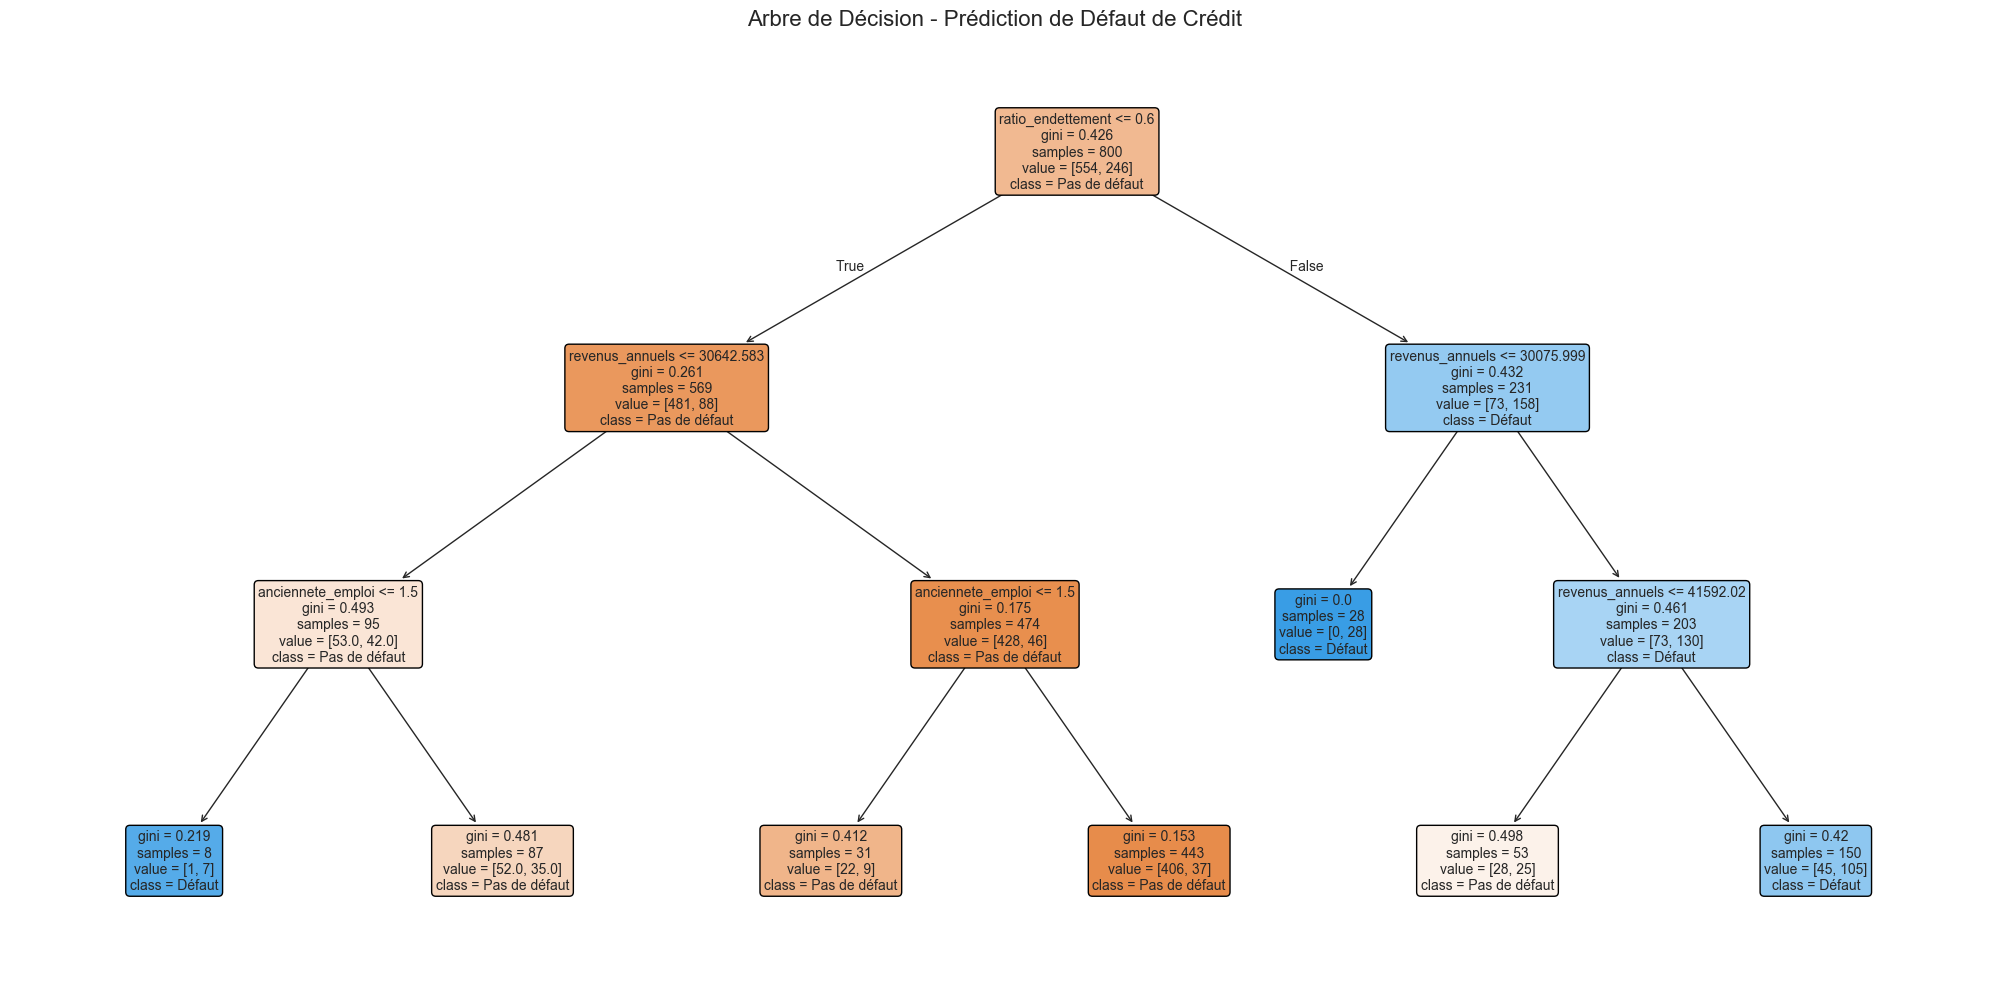


Représentation textuelle de l'arbre :
|--- ratio_endettement <= 0.60
|   |--- revenus_annuels <= 30642.58
|   |   |--- anciennete_emploi <= 1.50
|   |   |   |--- class: 1
|   |   |--- anciennete_emploi >  1.50
|   |   |   |--- class: 0
|   |--- revenus_annuels >  30642.58
|   |   |--- anciennete_emploi <= 1.50
|   |   |   |--- class: 0
|   |   |--- anciennete_emploi >  1.50
|   |   |   |--- class: 0
|--- ratio_endettement >  0.60
|   |--- revenus_annuels <= 30076.00
|   |   |--- class: 1
|   |--- revenus_annuels >  30076.00
|   |   |--- revenus_annuels <= 41592.02
|   |   |   |--- class: 0
|   |   |--- revenus_annuels >  41592.02
|   |   |   |--- class: 1



In [17]:
# TODO : Utilisez plot_tree pour visualiser l'arbre
plt.figure(figsize=(20, 10))
plot_tree(
    tree_credit,
    feature_names=X_credit.columns,
    class_names=['Pas de défaut', 'Défaut'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Arbre de Décision - Prédiction de Défaut de Crédit", fontsize=16)
plt.tight_layout()
plt.show()

# Affichage texte de l'arbre
print("\nReprésentation textuelle de l'arbre :")
print(export_text(tree_credit, feature_names=list(X_credit.columns)))

#### TODO 1.3 : Évaluez les performances

ÉVALUATION DU MODÈLE
Accuracy    : 0.7650
Precision   : 0.6829
Recall      : 0.4516
F1-Score    : 0.5437
ROC-AUC     : 0.8041


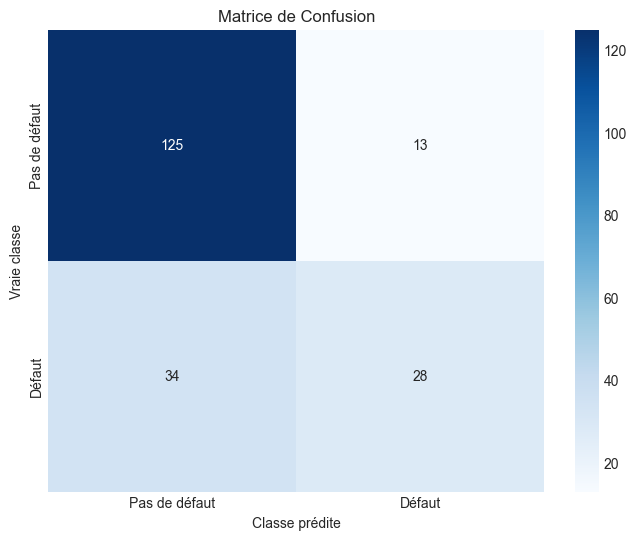


📊 Interprétation :
- Vrais négatifs (bonnes prédictions pas de défaut) : 125
- Faux positifs (prédit défaut mais pas de défaut)  : 13
- Faux négatifs (prédit pas de défaut mais défaut)  : 34
- Vrais positifs (bonnes prédictions défaut)        : 28


In [18]:
# TODO : Faites des prédictions sur le test set
y_pred = tree_credit.predict(X_test)
y_pred_proba = tree_credit.predict_proba(X_test)[:, 1]

# TODO : Calculez les métriques
print("=" * 50)
print("ÉVALUATION DU MODÈLE")
print("=" * 50)
print(f"Accuracy    : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision   : {precision_score(y_test, y_pred):.4f}")
print(f"Recall      : {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score    : {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC     : {roc_auc_score(y_test, y_pred_proba):.4f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pas de défaut', 'Défaut'],
            yticklabels=['Pas de défaut', 'Défaut'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

print("\n📊 Interprétation :")
print(f"- Vrais négatifs (bonnes prédictions pas de défaut) : {cm[0,0]}")
print(f"- Faux positifs (prédit défaut mais pas de défaut)  : {cm[0,1]}")
print(f"- Faux négatifs (prédit pas de défaut mais défaut)  : {cm[1,0]}")
print(f"- Vrais positifs (bonnes prédictions défaut)        : {cm[1,1]}")

**💡 Questions de réflexion :**
1. Quelle métrique est la plus importante en risque de crédit : Precision ou Recall ? Pourquoi ?
2. Que se passe-t-il si on augmente max_depth à 10 ?
3. Comment interprétez-vous les premières divisions de l'arbre ?

---
### Exercice 2 : Détection de Fraude Bancaire (15 min)

**Contexte :** Détecter des transactions frauduleuses dans les paiements par carte bancaire.

**Particularité :** Dataset **très déséquilibré** (fraude rare)

**Objectifs :**
1. Gérer le déséquilibre des classes
2. Utiliser des métriques adaptées
3. Comparer Gini vs Entropie

In [25]:
# Génération de données de fraude (déséquilibrées)
np.random.seed(42)
n_samples = 5000

data_fraude = pd.DataFrame({
    'montant': np.random.lognormal(5, 1.5, n_samples),  # distribution log-normale
    'heure': np.random.randint(0, 24, n_samples),
    'nb_transactions_jour': np.random.poisson(3, n_samples),
    'distance_domicile': np.random.exponential(20, n_samples),
    'nouveau_marchand': np.random.binomial(1, 0.3, n_samples)
})

# Création de la fraude (2% de fraudes)
fraude_prob = (
    0.005 +  # probabilité de base très faible
    0.15 * (data_fraude['montant'] > 500) +  # montant élevé
    0.10 * ((data_fraude['heure'] < 6) | (data_fraude['heure'] > 22)) +  # horaires suspects
    0.08 * (data_fraude['distance_domicile'] > 50) +  # loin du domicile
    0.05 * (data_fraude['nb_transactions_jour'] > 5)  # trop de transactions
)
fraude_prob = np.clip(fraude_prob, 0, 1)
data_fraude['fraude'] = (np.random.random(n_samples) < fraude_prob).astype(int)

print("Dataset fraude - Premières lignes :")
print(data_fraude.head())
print(f"\nTaux de fraude : {data_fraude['fraude'].mean():.2%}")
print(f"Distribution des classes : \n{data_fraude['fraude'].value_counts()}")
print(f"\nDéséquilibre : {(1-data_fraude['fraude'].mean()) / data_fraude['fraude'].mean():.1f}:1")

Dataset fraude - Premières lignes :
       montant  heure  nb_transactions_jour  distance_domicile  \
0   312.645897      7                     2          31.189471   
1   120.614987      0                     0           2.242833   
2   392.106234     23                     3           4.650221   
3  1457.597461     21                     0          14.508537   
4   104.456419      3                     1          12.441648   

   nouveau_marchand  fraude  
0                 0       0  
1                 1       0  
2                 0       1  
3                 0       1  
4                 0       0  

Taux de fraude : 7.60%
Distribution des classes : 
fraude
0    4620
1     380
Name: count, dtype: int64

Déséquilibre : 12.2:1


#### TODO 2.1 : Entraînez un modèle avec gestion du déséquilibre

In [26]:
# Préparation des données
X_fraude = data_fraude.drop('fraude', axis=1)
y_fraude = data_fraude['fraude']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fraude, y_fraude, test_size=0.2, random_state=42, stratify=y_fraude
)

# TODO : Créez un arbre avec class_weight='balanced' pour gérer le déséquilibre
tree_fraude = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',  # Important pour classes déséquilibrées !
    random_state=42
)

tree_fraude.fit(X_train_f, y_train_f)
print("Modèle fraude entraîné avec class_weight='balanced'")

Modèle fraude entraîné avec class_weight='balanced'


#### TODO 2.2 : Évaluez avec des métriques adaptées

DÉTECTION DE FRAUDE - MÉTRIQUES
Accuracy    : 0.6650
Precision   : 0.1471 (Fraudes prédites qui sont vraies)
Recall      : 0.7105 (Vraies fraudes détectées)
F1-Score    : 0.2438
ROC-AUC     : 0.7369


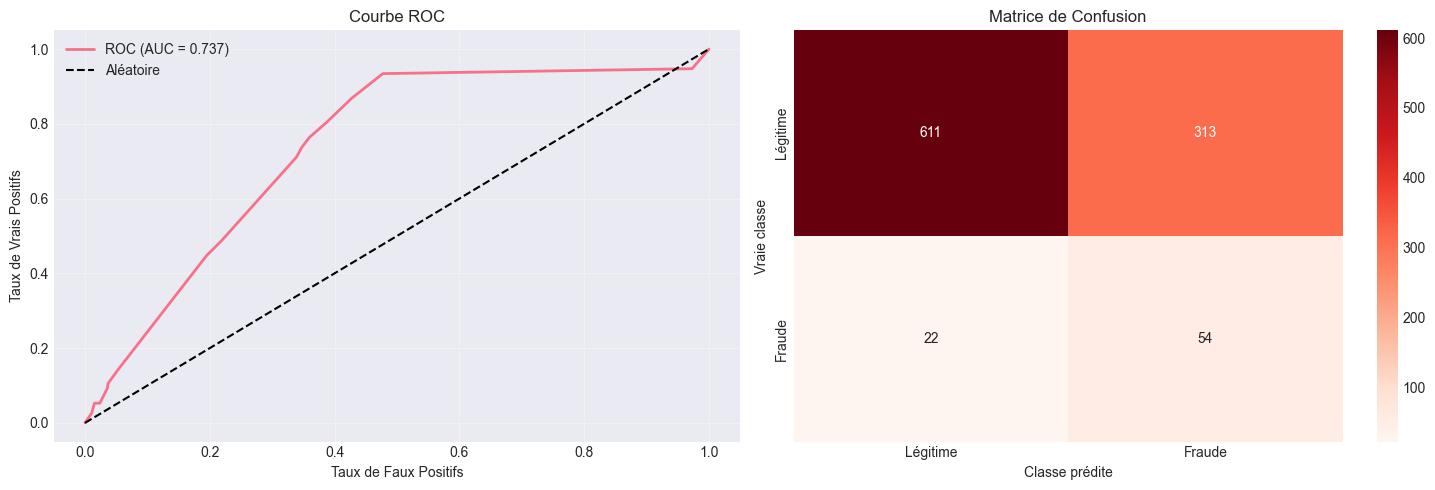


💰 Analyse métier :
Fraudes détectées : 54 / 76
Fausses alertes : 313 (coût opérationnel)
Fraudes manquées : 22 (perte financière directe)


In [27]:
# Prédictions
y_pred_f = tree_fraude.predict(X_test_f)
y_pred_proba_f = tree_fraude.predict_proba(X_test_f)[:, 1]

# Métriques
print("=" * 50)
print("DÉTECTION DE FRAUDE - MÉTRIQUES")
print("=" * 50)
print(f"Accuracy    : {accuracy_score(y_test_f, y_pred_f):.4f}")
print(f"Precision   : {precision_score(y_test_f, y_pred_f):.4f} (Fraudes prédites qui sont vraies)")
print(f"Recall      : {recall_score(y_test_f, y_pred_f):.4f} (Vraies fraudes détectées)")
print(f"F1-Score    : {f1_score(y_test_f, y_pred_f):.4f}")
print(f"ROC-AUC     : {roc_auc_score(y_test_f, y_pred_proba_f):.4f}")

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_f, y_pred_proba_f)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC Curve
axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc_score(y_test_f, y_pred_proba_f):.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Aléatoire')
axes[0].set_xlabel('Taux de Faux Positifs')
axes[0].set_ylabel('Taux de Vrais Positifs')
axes[0].set_title('Courbe ROC')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Matrice de confusion
cm_f = confusion_matrix(y_test_f, y_pred_f)
sns.heatmap(cm_f, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Légitime', 'Fraude'],
            yticklabels=['Légitime', 'Fraude'])
axes[1].set_title('Matrice de Confusion')
axes[1].set_ylabel('Vraie classe')
axes[1].set_xlabel('Classe prédite')

plt.tight_layout()
plt.show()

print("\n💰 Analyse métier :")
print(f"Fraudes détectées : {cm_f[1,1]} / {cm_f[1,0] + cm_f[1,1]}")
print(f"Fausses alertes : {cm_f[0,1]} (coût opérationnel)")
print(f"Fraudes manquées : {cm_f[1,0]} (perte financière directe)")

#### TODO 2.3 : Comparez Gini vs Entropie

In [22]:
# TODO : Entraînez deux modèles identiques sauf le critère
tree_gini = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=50,
    class_weight='balanced',
    random_state=42
)

tree_entropy = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    min_samples_split=50,
    class_weight='balanced',
    random_state=42
)

tree_gini.fit(X_train_f, y_train_f)
tree_entropy.fit(X_train_f, y_train_f)

# Comparaison
scores_comparison = pd.DataFrame({
    'Critère': ['Gini', 'Entropie'],
    'Accuracy': [
        accuracy_score(y_test_f, tree_gini.predict(X_test_f)),
        accuracy_score(y_test_f, tree_entropy.predict(X_test_f))
    ],
    'Precision': [
        precision_score(y_test_f, tree_gini.predict(X_test_f)),
        precision_score(y_test_f, tree_entropy.predict(X_test_f))
    ],
    'Recall': [
        recall_score(y_test_f, tree_gini.predict(X_test_f)),
        recall_score(y_test_f, tree_entropy.predict(X_test_f))
    ],
    'F1-Score': [
        f1_score(y_test_f, tree_gini.predict(X_test_f)),
        f1_score(y_test_f, tree_entropy.predict(X_test_f))
    ],
    'ROC-AUC': [
        roc_auc_score(y_test_f, tree_gini.predict_proba(X_test_f)[:, 1]),
        roc_auc_score(y_test_f, tree_entropy.predict_proba(X_test_f)[:, 1])
    ]
})

print("\n📊 COMPARAISON GINI vs ENTROPIE")
print(scores_comparison.to_string(index=False))
print("\n💡 En général, les différences sont minimes. Gini est plus rapide.")


📊 COMPARAISON GINI vs ENTROPIE
 Critère  Accuracy  Precision   Recall  F1-Score  ROC-AUC
    Gini     0.633   0.145985 0.789474  0.246407 0.728768
Entropie     0.633   0.145985 0.789474  0.246407 0.728768

💡 En général, les différences sont minimes. Gini est plus rapide.


---
### Exercice 3 : Pruning et Régularisation (15 min)

**Objectifs :**
1. Démontrer l'overfitting
2. Appliquer le Cost Complexity Pruning
3. Trouver l'alpha optimal

#### TODO 3.1 : Démontrez l'overfitting

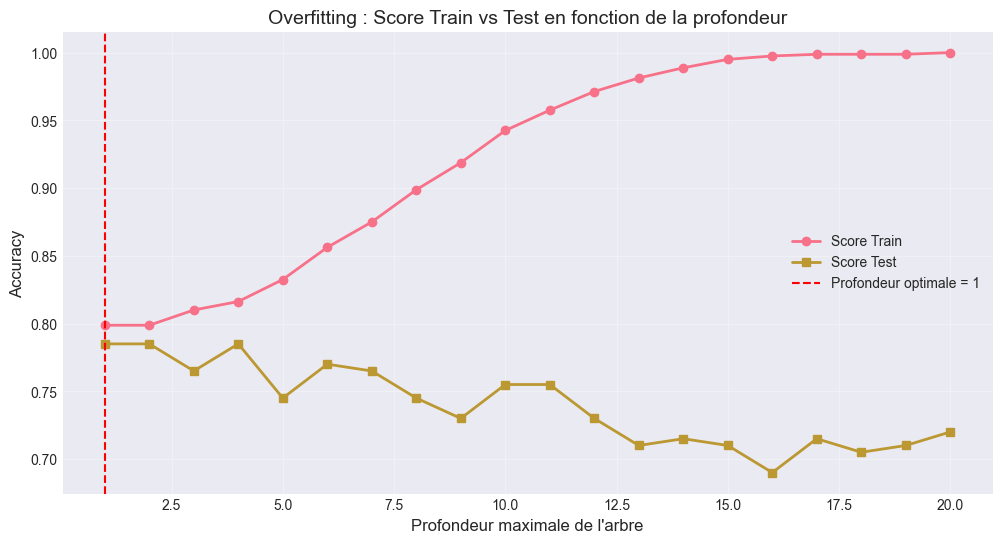


Profondeur optimale sur test : 1
Score max sur test : 0.7850

Overfit visible : à partir de profondeur 2, le score test stagne ou diminue alors que le score train continue d'augmenter


In [29]:
# TODO : Entraînez des arbres de profondeur croissante
depths = range(1, 21)
train_scores = []
test_scores = []

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    train_scores.append(tree.score(X_train, y_train))
    test_scores.append(tree.score(X_test, y_test))

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(depths, train_scores, 'o-', label='Score Train', linewidth=2)
plt.plot(depths, test_scores, 's-', label='Score Test', linewidth=2)
plt.xlabel('Profondeur maximale de l\'arbre', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Overfitting : Score Train vs Test en fonction de la profondeur', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axvline(x=depths[np.argmax(test_scores)], color='red', linestyle='--', 
            label=f'Profondeur optimale = {depths[np.argmax(test_scores)]}')
plt.legend()
plt.show()

print(f"\nProfondeur optimale sur test : {depths[np.argmax(test_scores)]}")
print(f"Score max sur test : {max(test_scores):.4f}")
print(f"\nOverfit visible : à partir de profondeur {depths[np.argmax(test_scores)]+1}, "
      f"le score test stagne ou diminue alors que le score train continue d'augmenter")

#### TODO 3.2 : Cost Complexity Pruning

Nombre de valeurs alpha testées : 68
Range alpha : [0.000000, 0.115085]


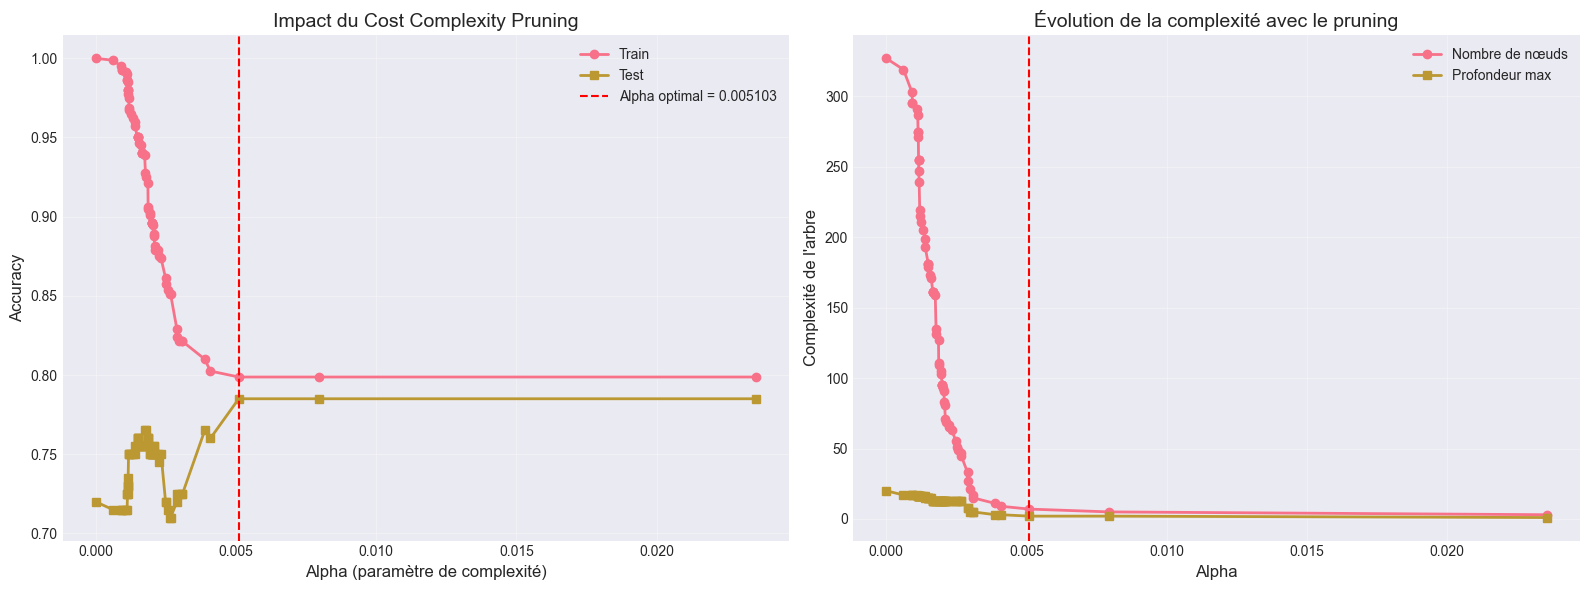


RÉSULTATS DU PRUNING
Alpha optimal : 0.005103
Score test optimal : 0.7850
Nombre de nœuds : 7
Profondeur : 2


In [30]:
# TODO : Trouvez le chemin de pruning optimal
# Entraînez un arbre complet
tree_full = DecisionTreeClassifier(random_state=42)
tree_full.fit(X_train, y_train)

# Obtenez les valeurs d'alpha pour le pruning
path = tree_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

print(f"Nombre de valeurs alpha testées : {len(ccp_alphas)}")
print(f"Range alpha : [{ccp_alphas[0]:.6f}, {ccp_alphas[-1]:.6f}]")

# Entraînez des arbres pour différentes valeurs d'alpha
trees_pruned = []
train_scores_alpha = []
test_scores_alpha = []

for ccp_alpha in ccp_alphas[:-1]:  # Exclure la dernière valeur (arbre vide)
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees_pruned.append(tree)
    train_scores_alpha.append(tree.score(X_train, y_train))
    test_scores_alpha.append(tree.score(X_test, y_test))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Scores vs alpha
axes[0].plot(ccp_alphas[:-1], train_scores_alpha, 'o-', label='Train', linewidth=2)
axes[0].plot(ccp_alphas[:-1], test_scores_alpha, 's-', label='Test', linewidth=2)
axes[0].set_xlabel('Alpha (paramètre de complexité)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Impact du Cost Complexity Pruning', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Trouver l'alpha optimal
best_idx = np.argmax(test_scores_alpha)
best_alpha = ccp_alphas[best_idx]
axes[0].axvline(x=best_alpha, color='red', linestyle='--', 
                label=f'Alpha optimal = {best_alpha:.6f}')
axes[0].legend()

# Graphique 2 : Nombre de feuilles vs alpha
node_counts = [tree.tree_.node_count for tree in trees_pruned]
depth_counts = [tree.tree_.max_depth for tree in trees_pruned]

axes[1].plot(ccp_alphas[:-1], node_counts, 'o-', label='Nombre de nœuds', linewidth=2)
axes[1].plot(ccp_alphas[:-1], depth_counts, 's-', label='Profondeur max', linewidth=2)
axes[1].set_xlabel('Alpha', fontsize=12)
axes[1].set_ylabel('Complexité de l\'arbre', fontsize=12)
axes[1].set_title('Évolution de la complexité avec le pruning', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=best_alpha, color='red', linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nRÉSULTATS DU PRUNING")
print(f"Alpha optimal : {best_alpha:.6f}")
print(f"Score test optimal : {test_scores_alpha[best_idx]:.4f}")
print(f"Nombre de nœuds : {trees_pruned[best_idx].tree_.node_count}")
print(f"Profondeur : {trees_pruned[best_idx].tree_.max_depth}")

#### TODO 3.3 : Comparaison avant/après pruning

In [31]:
# Modèle optimal avec pruning
tree_optimal = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
tree_optimal.fit(X_train, y_train)

# Comparaison
comparison = pd.DataFrame({
    'Modèle': ['Sans pruning', 'Avec pruning optimal'],
    'Score Train': [
        tree_full.score(X_train, y_train),
        tree_optimal.score(X_train, y_train)
    ],
    'Score Test': [
        tree_full.score(X_test, y_test),
        tree_optimal.score(X_test, y_test)
    ],
    'Nb nœuds': [
        tree_full.tree_.node_count,
        tree_optimal.tree_.node_count
    ],
    'Profondeur': [
        tree_full.tree_.max_depth,
        tree_optimal.tree_.max_depth
    ]
})

print("\n" + "="*70)
print("COMPARAISON AVANT/APRÈS PRUNING")
print("="*70)
print(comparison.to_string(index=False))
print("\nLe pruning réduit l'overfitting : score train plus bas mais score test maintenu ou amélioré !")
print("Modèle plus simple (moins de nœuds) = plus interprétable")


COMPARAISON AVANT/APRÈS PRUNING
              Modèle  Score Train  Score Test  Nb nœuds  Profondeur
        Sans pruning      1.00000       0.720       327          20
Avec pruning optimal      0.79875       0.785         7           2

Le pruning réduit l'overfitting : score train plus bas mais score test maintenu ou amélioré !
Modèle plus simple (moins de nœuds) = plus interprétable


---
### Exercice 4 : Interprétabilité et Visualisation (15 min)

**Objectifs :**
1. Analyser l'importance des variables
2. Tracer le chemin de décision pour une observation
3. Extraire des règles métier

#### TODO 4.1 : Importance des variables

IMPORTANCE DES VARIABLES
         Variable  Importance
ratio_endettement    0.785045
  revenus_annuels    0.214955
anciennete_emploi    0.000000
   nombre_credits    0.000000
              age    0.000000


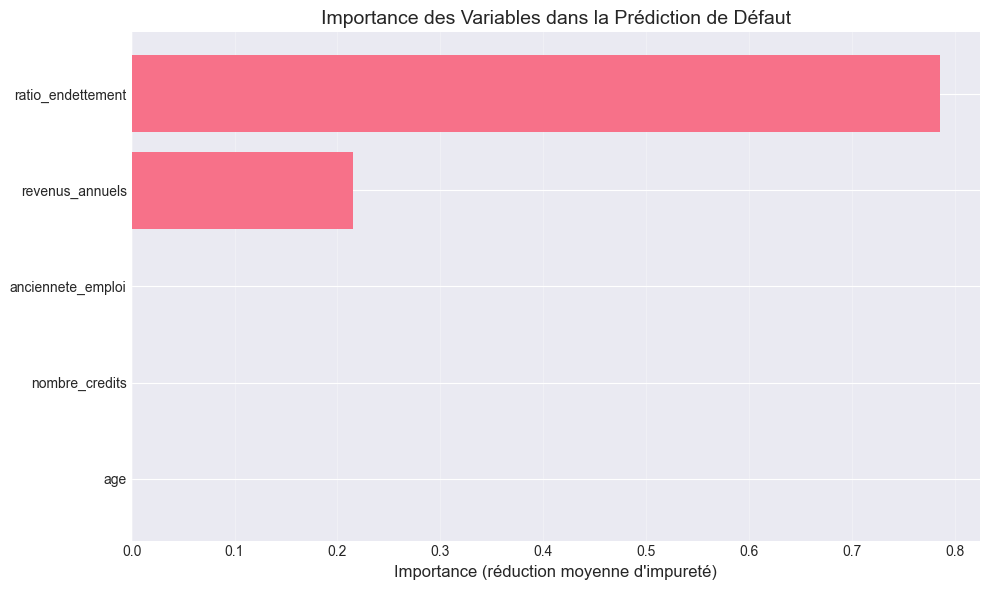


Interprétation :
La variable la plus importante est : ratio_endettement
Elle contribue à 78.5% des décisions de l'arbre


In [33]:
# TODO : Affichez l'importance des variables
feature_importance = pd.DataFrame({
    'Variable': X_credit.columns,
    'Importance': tree_optimal.feature_importances_
}).sort_values('Importance', ascending=False)

print("IMPORTANCE DES VARIABLES")
print("="*50)
print(feature_importance.to_string(index=False))

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Variable'], feature_importance['Importance'])
plt.xlabel('Importance (réduction moyenne d\'impureté)', fontsize=12)
plt.title('Importance des Variables dans la Prédiction de Défaut', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterprétation :")
print(f"La variable la plus importante est : {feature_importance.iloc[0]['Variable']}")
print(f"Elle contribue à {feature_importance.iloc[0]['Importance']:.1%} des décisions de l'arbre")

#### TODO 4.2 : Chemin de décision pour un client spécifique

In [34]:
# TODO : Analysez le chemin de décision pour un client
# Prenons un client du test set
client_idx = 42
client = X_test.iloc[[client_idx]]

print("CLIENT ANALYSÉ :")
print("="*50)
for col in client.columns:
    print(f"{col:20s} : {client[col].values[0]:>10.2f}")

# Prédiction
prediction = tree_optimal.predict(client)[0]
proba = tree_optimal.predict_proba(client)[0]

print(f"\nPRÉDICTION : {'DÉFAUT' if prediction == 1 else 'PAS DE DÉFAUT'}")
print(f"Probabilité de défaut : {proba[1]:.2%}")
print(f"Probabilité pas de défaut : {proba[0]:.2%}")

# Chemin de décision
decision_path = tree_optimal.decision_path(client)
node_indicator = decision_path.toarray()[0]
node_index = np.where(node_indicator)[0]

print(f"\nCHEMIN DE DÉCISION (passage par {len(node_index)} nœuds) :")
print("="*50)

feature_names = X_credit.columns
tree_structure = tree_optimal.tree_

for node_id in node_index:
    # Si c'est une feuille
    if tree_structure.feature[node_id] == -2:
        print(f"\n→ FEUILLE (nœud {node_id})")
        print(f"  Classe prédite : {tree_structure.value[node_id].argmax()}")
        print(f"  Distribution : {tree_structure.value[node_id][0]}")
    else:
        # C'est un nœud de décision
        feature = feature_names[tree_structure.feature[node_id]]
        threshold = tree_structure.threshold[node_id]
        client_value = client[feature].values[0]
        
        if client_value <= threshold:
            direction = "≤"
            next_node = "gauche"
        else:
            direction = ">"
            next_node = "droite"
        
        print(f"\nNœud {node_id}: {feature} {direction} {threshold:.2f}")
        print(f"  Valeur client : {client_value:.2f} → branche {next_node}")

CLIENT ANALYSÉ :
revenus_annuels      :   52706.79
ratio_endettement    :       0.34
anciennete_emploi    :       7.00
nombre_credits       :       1.00
age                  :      32.00

PRÉDICTION : PAS DE DÉFAUT
Probabilité de défaut : 9.70%
Probabilité pas de défaut : 90.30%

CHEMIN DE DÉCISION (passage par 3 nœuds) :

Nœud 0: ratio_endettement ≤ 0.60
  Valeur client : 0.34 → branche gauche

Nœud 1: revenus_annuels > 30642.58
  Valeur client : 52706.79 → branche droite

→ FEUILLE (nœud 3)
  Classe prédite : 0
  Distribution : [0.90295359 0.09704641]


#### TODO 4.3 : Extraction de règles métier

In [35]:
# Fonction pour extraire les règles
def extract_rules(tree, feature_names, class_names):
    """
    Extrait les règles de décision d'un arbre sous forme lisible
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]
    
    rules = []
    
    def recurse(node, depth, condition):
        indent = "  " * depth
        
        if tree_.feature[node] != -2:  # Pas une feuille
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # Branche gauche
            left_condition = condition + [f"{name} <= {threshold:.2f}"]
            recurse(tree_.children_left[node], depth + 1, left_condition)
            
            # Branche droite
            right_condition = condition + [f"{name} > {threshold:.2f}"]
            recurse(tree_.children_right[node], depth + 1, right_condition)
        else:  # Feuille
            classe = class_names[np.argmax(tree_.value[node])]
            n_samples = tree_.n_node_samples[node]
            rule = {
                'conditions': ' ET '.join(condition),
                'prediction': classe,
                'n_samples': n_samples
            }
            rules.append(rule)
    
    recurse(0, 0, [])
    return rules

# Extraction des règles
rules = extract_rules(tree_optimal, X_credit.columns, ['Pas de défaut', 'Défaut'])

print("\nRÈGLES MÉTIER EXTRAITES DE L'ARBRE")
print("="*80)

for i, rule in enumerate(rules, 1):
    print(f"\nRÈGLE {i} ({rule['n_samples']} clients):")
    print(f"SI : {rule['conditions']}")
    print(f"ALORS : {rule['prediction']}")

print("\n  Ces règles peuvent être :")
print("  - Validées par les experts métier")
print("  - Intégrées dans les processus de décision")
print("  - Utilisées pour expliquer les refus de crédit (conformité RGPD)")
print("  - Auditées par les régulateurs")


RÈGLES MÉTIER EXTRAITES DE L'ARBRE

RÈGLE 1 (95 clients):
SI : ratio_endettement <= 0.60 ET revenus_annuels <= 30642.58
ALORS : Pas de défaut

RÈGLE 2 (474 clients):
SI : ratio_endettement <= 0.60 ET revenus_annuels > 30642.58
ALORS : Pas de défaut

RÈGLE 3 (28 clients):
SI : ratio_endettement > 0.60 ET revenus_annuels <= 30076.00
ALORS : Défaut

RÈGLE 4 (203 clients):
SI : ratio_endettement > 0.60 ET revenus_annuels > 30076.00
ALORS : Défaut

  Ces règles peuvent être :
  - Validées par les experts métier
  - Intégrées dans les processus de décision
  - Utilisées pour expliquer les refus de crédit (conformité RGPD)
  - Auditées par les régulateurs


### Exercice 5 : Optimisation des Hyperparamètres avec GridSearchCV (20 min)

In [39]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Contexte : Optimiser systématiquement les hyperparamètres

print("GridSearchCV sur les paramètres de Pre-Pruning\n")

param_grid_prepruning = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [10, 30, 50, 100],
    'min_samples_leaf': [5, 10, 20, 50],
    'max_leaf_nodes': [10, 20, 30, None]
}

print(f"Nombre total de combinaisons : {np.prod([len(v) for v in param_grid_prepruning.values()])}")
print("Ce calcul peut prendre quelques minutes...\n")

grid_search_pre = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_prepruning,
    cv=5,
    scoring='f1',  # Métrique adaptée au crédit
    n_jobs=-1,     # Utilise tous les CPU
    verbose=1
)

# IMPORTANT : Entraîner le modèle avant d'accéder à best_estimator_
grid_search_pre.fit(X_train, y_train)

print("\n" + "="*70)
print("RÉSULTATS DU GRIDSEARCH - PRE-PRUNING")
print("="*70)
print(f"\nMeilleurs hyperparamètres :")
for param, value in grid_search_pre.best_params_.items():
    print(f"  {param:20s} : {value}")

print(f"\nMeilleur score F1 (CV) : {grid_search_pre.best_score_:.4f}")

print("\n\nGridSearchCV sur le paramètre de Post-Pruning\n")

# Étape 1 : Obtenir les valeurs candidates de ccp_alpha
tree_full = DecisionTreeClassifier(random_state=42)
tree_full.fit(X_train, y_train)

path = tree_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Sélection d'un sous-ensemble d'alphas
alpha_subset = np.concatenate([
    [0.0],  # Pas de pruning
    np.logspace(np.log10(ccp_alphas[1]), np.log10(ccp_alphas[-2]), 10)
])

param_grid_postpruning = {
    'ccp_alpha': alpha_subset  # Utiliser les valeurs calculées
}

grid_search_post = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_postpruning,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# IMPORTANT : Entraîner le modèle avant d'accéder à best_estimator_
grid_search_post.fit(X_train, y_train)

print("="*70)
print("RÉSULTATS DU GRIDSEARCH - POST-PRUNING")
print("="*70)
print(f"\nMeilleur ccp_alpha : {grid_search_post.best_params_['ccp_alpha']:.6f}")
print(f"Meilleur score F1 (CV) : {grid_search_post.best_score_:.4f}")

# TODO 3.3 : Visualisation de l'impact du post-pruning
def visualize_pruning_impact(alpha_values, scores, complexities):
    """Visualise l'impact du pruning sur les performances et la complexité"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Graphique 1 : F1-Score vs Alpha
    axes[0].plot(alpha_values, scores, 'o-', linewidth=2, markersize=8)
    axes[0].set_xlabel('ccp_alpha', fontsize=12)
    axes[0].set_ylabel('F1-Score (Validation Croisée)', fontsize=12)
    axes[0].set_title('Impact du Post-Pruning sur les Performances', 
                     fontsize=14, fontweight='bold')
    axes[0].set_xscale('log')
    axes[0].grid(True, alpha=0.3)
    
    # Graphique 2 : Complexité vs Alpha
    axes[1].plot(alpha_values, complexities, 'o-', linewidth=2, markersize=8, 
                label='Nombre de feuilles')
    axes[1].set_xlabel('ccp_alpha', fontsize=12)
    axes[1].set_ylabel('Nombre de feuilles', fontsize=12)
    axes[1].set_title('Impact du Post-Pruning sur la Complexité', 
                     fontsize=14, fontweight='bold')
    axes[1].set_xscale('log')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()


def compare_models(models_dict, X_test, y_test):
    """
    Compare plusieurs modèles
    
    Parameters:
    -----------
    models_dict : dict
        Dictionnaire {nom: modèle}
    X_test, y_test : données de test
    """
    results = []
    
    for name, model in models_dict.items():
        y_pred = model.predict(X_test)
        
        results.append({
            'Modèle': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'Profondeur': model.get_depth(),
            'Nb Feuilles': model.get_n_leaves()
        })
    
    comparison_df = pd.DataFrame(results)
    
    print("\n" + "="*100)
    print("COMPARAISON FINALE : PRE-PRUNING vs POST-PRUNING")
    print("="*100)
    print(comparison_df.to_string(index=False))
    
    # Identification du meilleur modèle
    best_idx = comparison_df['F1-Score'].idxmax()
    print(f"\n MEILLEUR MODÈLE : {comparison_df.loc[best_idx, 'Modèle']}")
    print(f"   F1-Score : {comparison_df.loc[best_idx, 'F1-Score']:.4f}")
    print(f"   Complexité : {comparison_df.loc[best_idx, 'Nb Feuilles']:.0f} feuilles")
    
    print("\n  Conclusions :")
    print("   - GridSearchCV permet d'optimiser systématiquement les hyperparamètres")
    print("   - Pre-pruning : plus rapide, contrôle intuitif")
    print("   - Post-pruning : explore toutes les possibilités")
    print("   - En production : combiner les deux pour un modèle optimal")
    
    return comparison_df

models = {
    'Pre-Pruning': grid_search_pre.best_estimator_,
    'Post-Pruning': grid_search_post.best_estimator_,
}
comparison_df = compare_models(models, X_test, y_test)

GridSearchCV sur les paramètres de Pre-Pruning

Nombre total de combinaisons : 320
Ce calcul peut prendre quelques minutes...

Fitting 5 folds for each of 320 candidates, totalling 1600 fits

RÉSULTATS DU GRIDSEARCH - PRE-PRUNING

Meilleurs hyperparamètres :
  max_depth            : 3
  max_leaf_nodes       : 10
  min_samples_leaf     : 50
  min_samples_split    : 10

Meilleur score F1 (CV) : 0.6573


GridSearchCV sur le paramètre de Post-Pruning

Fitting 5 folds for each of 11 candidates, totalling 55 fits
RÉSULTATS DU GRIDSEARCH - POST-PRUNING

Meilleur ccp_alpha : 0.010482
Meilleur score F1 (CV) : 0.6573

COMPARAISON FINALE : PRE-PRUNING vs POST-PRUNING
      Modèle  Accuracy  Precision   Recall  F1-Score  Profondeur  Nb Feuilles
 Pre-Pruning     0.785   0.666667 0.612903  0.638655           3            6
Post-Pruning     0.785   0.666667 0.612903  0.638655           2            3

 MEILLEUR MODÈLE : Pre-Pruning
   F1-Score : 0.6387
   Complexité : 6 feuilles

  Conclusions :
   -

---
## Partie 3 : Projet Non Guidé (1h30)

### Mission : Construire un modèle de scoring crédit optimal

**Dataset :** German Credit Data (données réelles)

**Contexte :**  
Vous travaillez pour une banque qui souhaite automatiser son processus d'octroi de crédit. Vous devez construire un modèle d'arbre de décision performant et interprétable qui prédit le risque de défaut d'un client.

**Contraintes métier :**
- Le modèle doit être **explicable** (pour justifier les refus)
- Privilégier le **Recall** (détecter un maximum de défauts potentiels)
- Maintenir une **Precision raisonnable** (éviter trop de refus injustifiés)
- Le modèle ne doit pas être trop complexe (max 15-20 feuilles pour l'interprétabilité)

**Livrables attendus :**
1.  Analyse exploratoire des données
2.  Préparation et feature engineering
3.  Plusieurs itérations de modèles avec justifications
4.  Comparaison des performances
5.  Modèle final optimisé
6.  Interprétation et règles métier
7.  Recommandations pour la production

**Méthodologie suggérée :**
- Itération 1 : Modèle baseline simple
- Itération 2 : Tuning des hyperparamètres
- Itération 3 : Feature engineering
- Itération 4 : Optimisation finale

---

### Étape 1 : Chargement du German Credit Dataset

In [37]:
# Chargement du dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

# Noms des colonnes
column_names = [
    'status_compte', 'duree', 'historique_credit', 'objet', 'montant',
    'epargne', 'anciennete_emploi', 'taux_mensualite', 'statut_personnel',
    'autres_debiteurs', 'residence_depuis', 'propriete', 'age',
    'autres_credits', 'logement', 'credits_existants', 'emploi',
    'personnes_charge', 'telephone', 'travailleur_etranger', 'risque'
]

# Lecture
df = pd.read_csv(url, sep=' ', names=column_names)

# La variable cible : 1 = bon risque, 2 = mauvais risque
# On transforme en 0/1 où 1 = défaut (mauvais risque)
df['defaut'] = (df['risque'] == 2).astype(int)
df = df.drop('risque', axis=1)

print("GERMAN CREDIT DATASET CHARGÉ")
print("="*70)
print(f"Nombre d'observations : {len(df)}")
print(f"Nombre de variables : {len(df.columns)-1}")
print(f"Taux de défaut : {df['defaut'].mean():.2%}")
print(f"\nPremières lignes :")
print(df.head())

print("\nInformations sur les variables :")
print(df.info())

GERMAN CREDIT DATASET CHARGÉ
Nombre d'observations : 1000
Nombre de variables : 20
Taux de défaut : 30.00%

Premières lignes :
  status_compte  duree historique_credit objet  montant epargne  \
0           A11      6               A34   A43     1169     A65   
1           A12     48               A32   A43     5951     A61   
2           A14     12               A34   A46     2096     A61   
3           A11     42               A32   A42     7882     A61   
4           A11     24               A33   A40     4870     A61   

  anciennete_emploi  taux_mensualite statut_personnel autres_debiteurs  ...  \
0               A75                4              A93             A101  ...   
1               A73                2              A92             A101  ...   
2               A74                2              A93             A101  ...   
3               A74                2              A93             A103  ...   
4               A73                3              A93             A101  ...

### INDICATIONS POUR LE PROJET

Voici quelques pistes pour vous guider (mais vous êtes libres d'explorer d'autres approches !) :

#### 1. Analyse exploratoire
- Étudiez la distribution des variables
- Identifiez les variables catégorielles vs numériques
- Analysez la corrélation avec la variable cible
- Détectez les valeurs aberrantes

#### 2. Prétraitement
- Les variables sont encodées en codes numériques (A11, A12, etc.)
- Vous pouvez créer des variables dérivées (ex: ratio montant/durée)
- Testez différentes transformations

#### 3. Modélisation itérative
- **Baseline :** Modèle simple sans tuning
- **Itération 2 :** GridSearchCV sur les hyperparamètres clés
- **Itération 3 :** Feature engineering
- **Itération 4 :** Optimisation avec pruning

#### 4. Métriques à suivre
- Recall (prioritaire pour détecter les défauts)
- Precision (éviter trop de faux positifs)
- F1-Score
- ROC-AUC
- Matrice de confusion

#### 5. Interprétation
- Visualisez l'arbre final
- Extrayez les règles métier
- Analysez l'importance des variables
- Testez sur des cas spécifiques

#### 6. Questions à se poser
- Quel est le coût d'un faux négatif vs faux positif ?
- Comment ajuster le threshold de décision ?
- Le modèle est-il suffisamment simple pour être expliqué ?
- Y a-t-il des biais potentiels à corriger ?

---

### À VOUS DE JOUER !

Créez autant de cellules que nécessaire pour :
1. Explorer les données
2. Créer vos features
3. Entraîner vos modèles
4. Comparer les performances
5. Interpréter les résultats

**Conseil :** Commentez votre code et vos choix pour montrer votre raisonnement !

In [ ]:
# VOTRE CODE ICI - Cellule 1 : Analyse exploratoire



In [ ]:
# VOTRE CODE ICI - Cellule 2 : Préparation des données



In [ ]:
# VOTRE CODE ICI - Cellule 3 : Modèle baseline



In [ ]:
# VOTRE CODE ICI - Cellule 4 : Itération 2 - Tuning



In [ ]:
# VOTRE CODE ICI - Cellule 5 : Itération 3 - Feature engineering



In [ ]:
# VOTRE CODE ICI - Cellule 6 : Modèle final optimisé



In [ ]:
# VOTRE CODE ICI - Cellule 7 : Comparaison des modèles



In [ ]:
# VOTRE CODE ICI - Cellule 8 : Interprétation et règles métier



In [ ]:
# VOTRE CODE ICI - Cellule 9 : Tests sur cas spécifiques



---
## Synthèse et Recommandations

### TODO : Rédigez votre synthèse finale

Répondez aux questions suivantes dans une cellule Markdown :

1. **Meilleur modèle :** Quel modèle avez-vous retenu et pourquoi ?

2. **Performances :** Quelles sont les métriques finales ?

3. **Variables clés :** Quelles sont les 3-5 variables les plus importantes ?

4. **Règles métier :** Donnez 2-3 exemples de règles extraites

5. **Mise en production :** Quelles recommandations pour déployer ce modèle ?

6. **Limites :** Quelles sont les limites de votre approche ?

7. **Améliorations :** Que pourriez-vous améliorer avec plus de temps ?

---

### VOTRE SYNTHÈSE ICI

**1. Meilleur modèle :**

[Votre réponse]

**2. Performances :**

[Votre réponse]

**3. Variables clés :**

[Votre réponse]

**4. Règles métier :**

[Votre réponse]

**5. Mise en production :**

[Votre réponse]

**6. Limites :**

[Votre réponse]

**7. Améliorations :**

[Votre réponse]

---
## 📚 Ressources Complémentaires

### Documentation scikit-learn
- [Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
- [DecisionTreeClassifier API](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

### Pour aller plus loin
- Random Forests (prochain TD)
- Gradient Boosting (XGBoost, LightGBM, CatBoost)

### Références académiques
- Breiman, L. (2001). "Random Forests". Machine Learning.
- Hastie, T., Tibshirani, R., & Friedman, J. (2009). "The Elements of Statistical Learning".

---